# Exercise 1

Name: Adam Dzadon

Student number: 2407741

## Libraries

First, let us import and install all the libraries we are going to use for the exercise.

We are going to use:

*   [PyTorch](https://pytorch.org/) for neural network building blocks and training resources
*   [Pandas](https://pandas.pydata.org/docs/) for pretty table printing
*   [NumPy](https://numpy.org/doc/) for fast numerical computations
*   [Matplotlib](https://matplotlib.org/stable/index.html) for data visualization
*   [tqdm](https://tqdm.github.io/) for progress bar during the training


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 12.7 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## NN architecture

Next, we are going to implement our CNN:

In [ ]:
class CNN(nn.Module):
    def __init__(self,
                 in_size: tuple[int, int],
                 in_dim: int,
                 out_classes: int,
                 activation: nn.Module,
                 output_activation) -> None:
        """
        Parameters:
            - in_size          : spatial dimensions of input images
            - in_dim           : number of channels of input images
            - out_classes      : target number of classes
            - activation       : node function used in hidden layers
            - output_actiation : final activation
        """
        super().__init__()

        conv_w = in_size[0] // 8
        conv_h = in_size[1] // 8

        self.network = nn.Sequential(
            nn.Conv2d(in_dim, 32, 3, padding="same"),
            activation(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding="same"),
            activation(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding="same"),
            activation(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(128 * conv_w * conv_h, 64),
            activation(),
            nn.Linear(64, out_classes)
        )

        self.output_activation = output_activation

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.output_activation(self.network(x))

At the abstract level, our CNN consists of two main parts:

*   Feature extractor
*   Classifier

The purpose of feature extractor is to extract features from the input image. In classical ML setup, this would be done by humans beforehand. For feature extraction, convolutional layers are used in our models. They offer high level of positional invariance of the features. Each convolution kernel is "looking" for a specific feature in the whole input. In deeper layers, the convolutions work with already processed version of the image, thus, looking for more abstract concepts. Finally, the pooling layers reduce the spatial dimension and increase the positional invariance.

Regarding the classifier, it is a classic MLP network taking a vector of "features" as an input, and returns a probability vector giving a probability that the sample belongs to each class.

## Data preparation

In this exercise, we work with two datasets:


*   MNIST
*   CIFAR10



Both of these are already present and preprocessed in PyTorch library, thus, we are going to use them.

Let us visualize a couple of images together with their corresponding labels (expected outputs):

In [ ]:
def show_images(ims: list[torch.tensor], labels: list[int | str], preds: list[int | str]=None, mnist: bool=True) -> None:
    assert len(ims) == len(labels)

    rows, cols = len(ims) // 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i in range(len(ims)):
        row, col = divmod(i, cols)

        if mnist:
            image_np = (ims[i].permute(1, 2, 0) * 255).to(torch.uint8).numpy()
            axes[row, col].imshow(image_np, cmap='gray')
        else:
            image_np = (((ims[i].permute(1, 2, 0) + 1) / 2) * 255).to(torch.uint8).numpy()
            axes[row, col].imshow(image_np)

        axes[row, col].axis('off')

        desc = "Target: " + str(labels[i]) + "\n" + "Prediction: " + str(preds[i]) if preds is not None else labels[i]
        axes[row, col].set_title(desc, fontsize=12)

### MNIST

In [ ]:
MNIST_train = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

MNIST_test = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 38.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 8.40MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.23MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Let us observe how many images are there in the train and test set respectively:

In [ ]:
print("Train size:", len(MNIST_train))
print("Test size:", len(MNIST_test))

Train size: 60000
Test size: 10000


Next, let us see the dimensions of our images:

In [ ]:
im = MNIST_train[0][0]
print("Dimensions:", im.shape)
MNIST_dims = im.shape[1], im.shape[2]
print("Pixel boundaries:", torch.min(im), torch.max(im))

Dimensions: torch.Size([1, 28, 28])
Pixel boundaries: tensor(0.) tensor(1.)


We observe that they are grayscale (1 color channel) 28x28 images. Also, we see that they are scaled in [0,1] interaval.

Since the data are already preprocessed and normalized, we do not need to preprocess it any further.

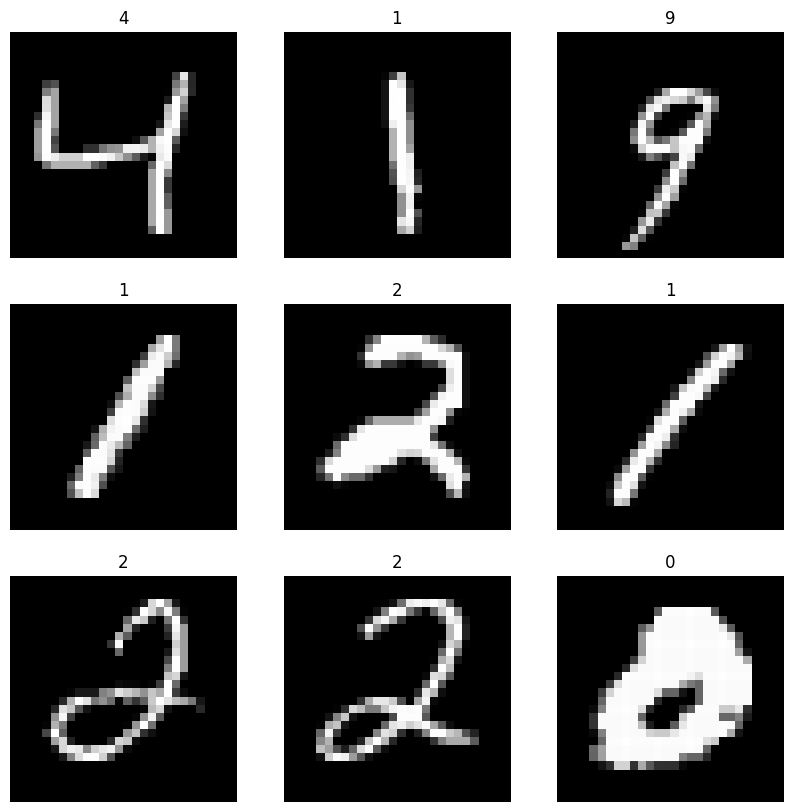

In [ ]:
indices = [2, 8, 153, 205, 308, 587, 1124, 1584, 1963]
show_images( [MNIST_train[i][0] for i in indices], [MNIST_train[i][1] for i in indices] )

### CIFAR10

Next, we will continue with CIFAR10 dataset:

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)

In [ ]:
CIFAR10_train = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms,
)

CIFAR10_test = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms,
)

100%|██████████| 170M/170M [00:02<00:00, 81.7MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


We also add a translation for the target classes (from numbers encoding them to names of the classes):

In [ ]:
CIFAR10_translate = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Again, let us observe some characteristics of our data:

In [ ]:
print("Train size:", len(CIFAR10_train))
print("Test size:", len(CIFAR10_test))

Train size: 50000
Test size: 10000


We observe that this time, we have a bit less training data.

In [ ]:
im = CIFAR10_train[0][0]
print("Dimensions:", im.shape)
CIFAR10_dims = im.shape[1], im.shape[2]
print("Pixel boundaries:", torch.min(im), torch.max(im))

Dimensions: torch.Size([3, 32, 32])
Pixel boundaries: tensor(-1.) tensor(1.)


This time, we see that the images are RGB (3 color channels) and are a bit larger - 32x32. Again, they are rescaled into [-1, 1] interval.

Finally, let us show some images from the dataset:

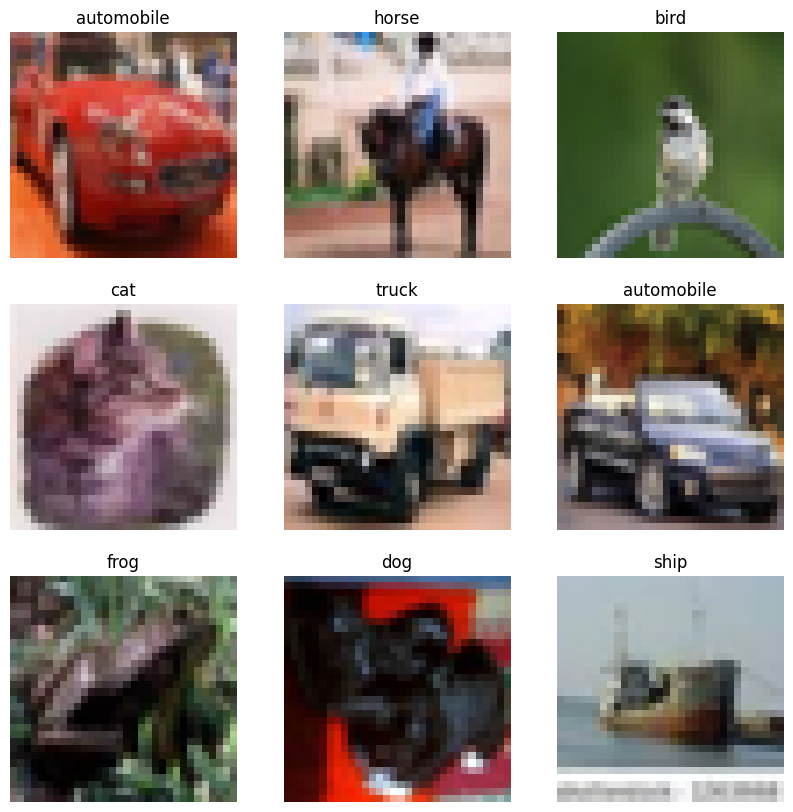

In [ ]:
indices = [5, 11, 54, 174, 269, 354, 4123, 5698, 9951]
show_images([CIFAR10_train[i][0] for i in indices], [CIFAR10_translate[CIFAR10_train[i][1]] for i in indices], mnist=False)

## Training

Now, we are going to train a collection of models. Namely, for each of the following activation functions...

*   Sigmoid
*   Hyperbolic Tangent
*   ReLU
*   ELU
*   SELU

... and for each dataset, we are going to create one model. This makes 5 * 2 = 10 models in total. We are going to use TPUs for the training acceleration.



Let us collect the objects computing the mentioned activation functions:

In [ ]:
activations = [nn.Sigmoid, nn.Tanh, nn.ReLU, nn.ELU, nn.SELU]

We also define the training procedure together with validation after each epoch:

In [ ]:
def train(train_data: DataLoader,
          val_data: DataLoader,
          model: nn.Module,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int) -> tuple[
              list[float], list[float], list[float], list[float]
              ]:
    """
    Parameters:
        - train_data: DataLoader containing training data
        - val_data  : DataLoader containing validation (test) data
        - model     : CNN to be trained
        - loss_fn   : Loss function used
        - optimizer : Object performing weight optimization
        - epochs    : Number of epochs
    """

    # --- Initialize accuracy computing unit
    acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
    # ---

    # --- We are going to measure loss and accuracy on train and validation set for each epoch
    train_n_batches = len(train_data)
    val_n_batches = len(val_data)
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    # ---

    for epoch in range(epochs):

        # --- Training
        print(f"Starting epoch n.{epoch + 1} of training...")
        epoch_loss = 0
        epoch_acc = 0
        progress_bar = tqdm(train_data, desc=f"Epoch {epoch + 1}/{epochs}")

        for X_batch, Y_batch in progress_bar:
            optimizer.zero_grad() # zero gradients
            output = model(X_batch) # calculate model prediction
            l = loss_fn(output, Y_batch) # calculate loss
            l.backward() # calculate gradient
            optimizer.step() # update weights

            epoch_loss += l.item()
            epoch_acc += acc(output, Y_batch).item()

        train_loss.append(epoch_loss / train_n_batches) # epoch loss as an average for all batches
        train_acc.append(epoch_acc / train_n_batches) # epoch accuracy as an average for all batches
        # ---

        # --- Testing
        print("Starting validation...")
        epoch_loss = 0
        epoch_acc = 0

        with torch.no_grad():   # no need of gradient for validation
            val_progress_bar = tqdm(val_data, desc="Validation progress")
            for X_batch, Y_batch in val_progress_bar:

                pred = model(X_batch)

                epoch_loss += loss_fn(pred, Y_batch).item()
                epoch_acc += acc(pred, Y_batch).item()

            val_loss.append(epoch_loss / val_n_batches)
            val_acc.append(epoch_acc / val_n_batches)
            print("Epoch accuracy: ", epoch_acc / val_n_batches)

        print()
        # ---

    return train_loss, val_loss, train_acc, val_acc

### Model training on MNIST

First, we define training hyper-parameters:

In [ ]:
batch_size = 64
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam
lr = 0.001
epochs = 10

Next, we create a DataLoader for MNIST dataset. We are going to use multiple processing for data loading to accelerate the training process.

In [ ]:
MNIST_train_dataloader = DataLoader(MNIST_train, batch_size=batch_size, num_workers=16)
MNIST_test_dataloader = DataLoader(MNIST_test, batch_size=batch_size, num_workers=8)

Then, we create a model for each activation function:

In [ ]:
MNIST_models = [CNN(MNIST_dims, 1, 10, activation, nn.Softmax(dim=1)) for activation in activations]

Finally, we perform the training and capture the loss and accuracy per epoch:

In [ ]:
MNIST_train_losses = []
MNIST_val_losses = []
MNIST_train_accs = []
MNIST_val_accs = []

for model in MNIST_models:
    print(model)
    opt = optim(model.parameters(), lr=lr)
    tl, vl, ta, va = train(MNIST_train_dataloader, MNIST_test_dataloader, model, loss, opt, epochs)
    MNIST_train_losses.append(tl)
    MNIST_val_losses.append(vl)
    MNIST_train_accs.append(ta)
    MNIST_val_accs.append(va)

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): Sigmoid()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=64, bias=True)
    (11): Sigmoid()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (output_activation): Softmax(dim=1)
)
Starting epoch n.1 of training...


Epoch 1/10: 100%|██████████| 938/938 [00:12<00:00, 73.04it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 100.04it/s]


Epoch accuracy:  0.8635549363057324

Starting epoch n.2 of training...


Epoch 2/10: 100%|██████████| 938/938 [00:12<00:00, 72.96it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 100.83it/s]


Epoch accuracy:  0.9690485668789809

Starting epoch n.3 of training...


Epoch 3/10: 100%|██████████| 938/938 [00:12<00:00, 72.49it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 100.17it/s]


Epoch accuracy:  0.9784036624203821

Starting epoch n.4 of training...


Epoch 4/10: 100%|██████████| 938/938 [00:12<00:00, 72.24it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 102.52it/s]


Epoch accuracy:  0.9837778662420382

Starting epoch n.5 of training...


Epoch 5/10: 100%|██████████| 938/938 [00:12<00:00, 74.27it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.05it/s]


Epoch accuracy:  0.9810907643312102

Starting epoch n.6 of training...


Epoch 6/10: 100%|██████████| 938/938 [00:12<00:00, 72.58it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.79it/s] 


Epoch accuracy:  0.9864649681528662

Starting epoch n.7 of training...


Epoch 7/10: 100%|██████████| 938/938 [00:12<00:00, 75.37it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 104.99it/s]


Epoch accuracy:  0.9825835987261147

Starting epoch n.8 of training...


Epoch 8/10: 100%|██████████| 938/938 [00:13<00:00, 71.16it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.82it/s] 


Epoch accuracy:  0.9865644904458599

Starting epoch n.9 of training...


Epoch 9/10: 100%|██████████| 938/938 [00:12<00:00, 72.38it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.69it/s] 


Epoch accuracy:  0.9855692675159236

Starting epoch n.10 of training...


Epoch 10/10: 100%|██████████| 938/938 [00:13<00:00, 70.71it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.42it/s]


Epoch accuracy:  0.9863654458598726

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): Tanh()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=64, bias=True)
    (11): Tanh()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (output_activation): Softmax(dim=1)
)
Starting epoch n.1 of training...


Epoch 1/10: 100%|██████████| 938/938 [00:13<00:00, 71.64it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 104.83it/s]


Epoch accuracy:  0.9813893312101911

Starting epoch n.2 of training...


Epoch 2/10: 100%|██████████| 938/938 [00:12<00:00, 72.56it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 106.35it/s]


Epoch accuracy:  0.9893511146496815

Starting epoch n.3 of training...


Epoch 3/10: 100%|██████████| 938/938 [00:12<00:00, 75.13it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.24it/s]


Epoch accuracy:  0.9893511146496815

Starting epoch n.4 of training...


Epoch 4/10: 100%|██████████| 938/938 [00:12<00:00, 73.20it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 105.82it/s]


Epoch accuracy:  0.990047770700637

Starting epoch n.5 of training...


Epoch 5/10: 100%|██████████| 938/938 [00:12<00:00, 72.56it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 105.00it/s]


Epoch accuracy:  0.9904458598726115

Starting epoch n.6 of training...


Epoch 6/10: 100%|██████████| 938/938 [00:13<00:00, 69.23it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 107.75it/s]


Epoch accuracy:  0.9901472929936306

Starting epoch n.7 of training...


Epoch 7/10: 100%|██████████| 938/938 [00:12<00:00, 72.33it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 103.70it/s]


Epoch accuracy:  0.9884554140127388

Starting epoch n.8 of training...


Epoch 8/10: 100%|██████████| 938/938 [00:12<00:00, 73.69it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 105.69it/s]


Epoch accuracy:  0.9906449044585988

Starting epoch n.9 of training...


Epoch 9/10: 100%|██████████| 938/938 [00:12<00:00, 72.21it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 107.25it/s]


Epoch accuracy:  0.9907444267515924

Starting epoch n.10 of training...


Epoch 10/10: 100%|██████████| 938/938 [00:12<00:00, 72.94it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 105.49it/s]


Epoch accuracy:  0.9905453821656051

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (output_activation): Softmax(dim=1)
)
Starting epoch n.1 of training...


Epoch 1/10: 100%|██████████| 938/938 [00:13<00:00, 72.04it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 100.03it/s]


Epoch accuracy:  0.8664410828025477

Starting epoch n.2 of training...


Epoch 2/10: 100%|██████████| 938/938 [00:13<00:00, 69.88it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 105.23it/s]


Epoch accuracy:  0.8941082802547771

Starting epoch n.3 of training...


Epoch 3/10: 100%|██████████| 938/938 [00:12<00:00, 73.47it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.22it/s]


Epoch accuracy:  0.9764132165605095

Starting epoch n.4 of training...


Epoch 4/10: 100%|██████████| 938/938 [00:13<00:00, 71.53it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 102.96it/s]


Epoch accuracy:  0.9867635350318471

Starting epoch n.5 of training...


Epoch 5/10: 100%|██████████| 938/938 [00:13<00:00, 70.58it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 100.67it/s]


Epoch accuracy:  0.9855692675159236

Starting epoch n.6 of training...


Epoch 6/10: 100%|██████████| 938/938 [00:13<00:00, 67.65it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 106.11it/s]


Epoch accuracy:  0.9810907643312102

Starting epoch n.7 of training...


Epoch 7/10: 100%|██████████| 938/938 [00:15<00:00, 62.45it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 105.99it/s]


Epoch accuracy:  0.9898487261146497

Starting epoch n.8 of training...


Epoch 8/10: 100%|██████████| 938/938 [00:15<00:00, 61.88it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 100.94it/s]


Epoch accuracy:  0.9883558917197452

Starting epoch n.9 of training...


Epoch 9/10: 100%|██████████| 938/938 [00:17<00:00, 54.15it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 104.45it/s]


Epoch accuracy:  0.9871616242038217

Starting epoch n.10 of training...


Epoch 10/10: 100%|██████████| 938/938 [00:17<00:00, 52.95it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 104.20it/s]


Epoch accuracy:  0.9877587579617835

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ELU(alpha=1.0)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=64, bias=True)
    (11): ELU(alpha=1.0)
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (output_activation): Softmax(dim=1)
)
Starting epoch n.1 of training...


Epoch 1/10: 100%|██████████| 938/938 [00:12<00:00, 72.65it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.78it/s]


Epoch accuracy:  0.9756170382165605

Starting epoch n.2 of training...


Epoch 2/10: 100%|██████████| 938/938 [00:13<00:00, 72.08it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 103.55it/s]


Epoch accuracy:  0.9815883757961783

Starting epoch n.3 of training...


Epoch 3/10: 100%|██████████| 938/938 [00:14<00:00, 66.82it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.91it/s] 


Epoch accuracy:  0.982484076433121

Starting epoch n.4 of training...


Epoch 4/10: 100%|██████████| 938/938 [00:16<00:00, 58.40it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.59it/s] 


Epoch accuracy:  0.9851711783439491

Starting epoch n.5 of training...


Epoch 5/10: 100%|██████████| 938/938 [00:21<00:00, 43.98it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 105.74it/s]


Epoch accuracy:  0.9801950636942676

Starting epoch n.6 of training...


Epoch 6/10: 100%|██████████| 938/938 [00:29<00:00, 31.57it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.09it/s]


Epoch accuracy:  0.9837778662420382

Starting epoch n.7 of training...


Epoch 7/10: 100%|██████████| 938/938 [00:33<00:00, 28.26it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.87it/s] 


Epoch accuracy:  0.984375

Starting epoch n.8 of training...


Epoch 8/10: 100%|██████████| 938/938 [00:32<00:00, 28.47it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.73it/s]


Epoch accuracy:  0.988953025477707

Starting epoch n.9 of training...


Epoch 9/10: 100%|██████████| 938/938 [00:29<00:00, 31.52it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.65it/s]


Epoch accuracy:  0.9887539808917197

Starting epoch n.10 of training...


Epoch 10/10: 100%|██████████| 938/938 [00:27<00:00, 33.97it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 103.25it/s]


Epoch accuracy:  0.987062101910828

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): SELU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): SELU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): SELU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=64, bias=True)
    (11): SELU()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (output_activation): Softmax(dim=1)
)
Starting epoch n.1 of training...


Epoch 1/10: 100%|██████████| 938/938 [00:13<00:00, 70.37it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 102.05it/s]


Epoch accuracy:  0.979796974522293

Starting epoch n.2 of training...


Epoch 2/10: 100%|██████████| 938/938 [00:13<00:00, 71.95it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.92it/s] 


Epoch accuracy:  0.9780055732484076

Starting epoch n.3 of training...


Epoch 3/10: 100%|██████████| 938/938 [00:16<00:00, 55.75it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 103.94it/s]


Epoch accuracy:  0.9814888535031847

Starting epoch n.4 of training...


Epoch 4/10: 100%|██████████| 938/938 [00:26<00:00, 34.81it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 104.46it/s]


Epoch accuracy:  0.9836783439490446

Starting epoch n.5 of training...


Epoch 5/10: 100%|██████████| 938/938 [00:33<00:00, 27.97it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.29it/s]


Epoch accuracy:  0.984375

Starting epoch n.6 of training...


Epoch 6/10: 100%|██████████| 938/938 [00:32<00:00, 28.46it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 102.45it/s]


Epoch accuracy:  0.9835788216560509

Starting epoch n.7 of training...


Epoch 7/10: 100%|██████████| 938/938 [00:30<00:00, 31.05it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.71it/s] 


Epoch accuracy:  0.9841759554140127

Starting epoch n.8 of training...


Epoch 8/10: 100%|██████████| 938/938 [00:28<00:00, 32.62it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 102.69it/s]


Epoch accuracy:  0.9851711783439491

Starting epoch n.9 of training...


Epoch 9/10: 100%|██████████| 938/938 [00:23<00:00, 39.20it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 98.96it/s] 


Epoch accuracy:  0.9851711783439491

Starting epoch n.10 of training...


Epoch 10/10: 100%|██████████| 938/938 [00:22<00:00, 42.05it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 103.94it/s]

Epoch accuracy:  0.9802945859872612



### Model training on CIFAR10

Similar to the MNIST dataset, we set the training hyper-parameters:

In [ ]:
batch_size = 64
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam
lr = 0.001
epochs = 15

Then, we create DataLoaders for CIFAR10 dataset:

In [ ]:
CIFAR10_train_dataloader = DataLoader(CIFAR10_train, batch_size=batch_size, num_workers=16)
CIFAR10_test_dataloader = DataLoader(CIFAR10_test, batch_size=batch_size, num_workers=8)

Next, we define models for each activation function:

In [ ]:
CIFAR10_models = [CNN(CIFAR10_dims, 3, 10, activation, nn.Softmax(dim=1)) for activation in activations]

And finally, train the models:

In [ ]:
CIFAR10_train_losses = []
CIFAR10_val_losses = []
CIFAR10_train_accs = []
CIFAR10_val_accs = []

for model in CIFAR10_models:
    print(model)
    opt = optim(model.parameters(), lr=lr)
    tl, vl, ta, va = train(CIFAR10_train_dataloader, CIFAR10_test_dataloader, model, loss, opt, epochs)
    CIFAR10_train_losses.append(tl)
    CIFAR10_val_losses.append(vl)
    CIFAR10_train_accs.append(ta)
    CIFAR10_val_accs.append(va)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): Sigmoid()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=64, bias=True)
    (11): Sigmoid()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (output_activation): Softmax(dim=1)
)
Starting epoch n.1 of training...


Epoch 1/15: 100%|██████████| 782/782 [00:12<00:00, 61.46it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.56it/s] 


Epoch accuracy:  0.4339171974522293

Starting epoch n.2 of training...


Epoch 2/15: 100%|██████████| 782/782 [00:12<00:00, 63.54it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 98.09it/s] 


Epoch accuracy:  0.4658638535031847

Starting epoch n.3 of training...


Epoch 3/15: 100%|██████████| 782/782 [00:12<00:00, 64.58it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 97.81it/s] 


Epoch accuracy:  0.4801950636942675

Starting epoch n.4 of training...


Epoch 4/15: 100%|██████████| 782/782 [00:12<00:00, 63.56it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.03it/s] 


Epoch accuracy:  0.5005971337579618

Starting epoch n.5 of training...


Epoch 5/15: 100%|██████████| 782/782 [00:12<00:00, 62.15it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 94.54it/s] 


Epoch accuracy:  0.5173168789808917

Starting epoch n.6 of training...


Epoch 6/15: 100%|██████████| 782/782 [00:12<00:00, 62.25it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.89it/s] 


Epoch accuracy:  0.5288614649681529

Starting epoch n.7 of training...


Epoch 7/15: 100%|██████████| 782/782 [00:12<00:00, 62.46it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 94.69it/s] 


Epoch accuracy:  0.539609872611465

Starting epoch n.8 of training...


Epoch 8/15: 100%|██████████| 782/782 [00:12<00:00, 61.46it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.47it/s] 


Epoch accuracy:  0.5426950636942676

Starting epoch n.9 of training...


Epoch 9/15: 100%|██████████| 782/782 [00:12<00:00, 62.02it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 93.15it/s] 


Epoch accuracy:  0.5516520700636943

Starting epoch n.10 of training...


Epoch 10/15: 100%|██████████| 782/782 [00:12<00:00, 63.60it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.04it/s] 


Epoch accuracy:  0.5572253184713376

Starting epoch n.11 of training...


Epoch 11/15: 100%|██████████| 782/782 [00:12<00:00, 62.66it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 93.55it/s] 


Epoch accuracy:  0.5595143312101911

Starting epoch n.12 of training...


Epoch 12/15: 100%|██████████| 782/782 [00:12<00:00, 61.45it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 98.08it/s] 


Epoch accuracy:  0.56140525477707

Starting epoch n.13 of training...


Epoch 13/15: 100%|██████████| 782/782 [00:12<00:00, 61.67it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 93.95it/s] 


Epoch accuracy:  0.5625

Starting epoch n.14 of training...


Epoch 14/15: 100%|██████████| 782/782 [00:12<00:00, 61.27it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 97.62it/s] 


Epoch accuracy:  0.5647890127388535

Starting epoch n.15 of training...


Epoch 15/15: 100%|██████████| 782/782 [00:12<00:00, 63.59it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 93.79it/s] 


Epoch accuracy:  0.5675756369426752

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): Tanh()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=64, bias=True)
    (11): Tanh()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (output_activation): Softmax(dim=1)
)
Starting epoch n.1 of training...


Epoch 1/15: 100%|██████████| 782/782 [00:12<00:00, 63.75it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.97it/s] 


Epoch accuracy:  0.5496616242038217

Starting epoch n.2 of training...


Epoch 2/15: 100%|██████████| 782/782 [00:12<00:00, 64.05it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.74it/s] 


Epoch accuracy:  0.5952428343949044

Starting epoch n.3 of training...


Epoch 3/15: 100%|██████████| 782/782 [00:13<00:00, 59.92it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 98.08it/s] 


Epoch accuracy:  0.6390326433121019

Starting epoch n.4 of training...


Epoch 4/15: 100%|██████████| 782/782 [00:12<00:00, 64.80it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.27it/s] 


Epoch accuracy:  0.6542595541401274

Starting epoch n.5 of training...


Epoch 5/15: 100%|██████████| 782/782 [00:12<00:00, 62.71it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 95.21it/s] 


Epoch accuracy:  0.6502786624203821

Starting epoch n.6 of training...


Epoch 6/15: 100%|██████████| 782/782 [00:12<00:00, 64.04it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 94.80it/s] 


Epoch accuracy:  0.673765923566879

Starting epoch n.7 of training...


Epoch 7/15: 100%|██████████| 782/782 [00:12<00:00, 62.99it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 93.93it/s] 


Epoch accuracy:  0.6854100318471338

Starting epoch n.8 of training...


Epoch 8/15: 100%|██████████| 782/782 [00:11<00:00, 65.31it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.88it/s] 


Epoch accuracy:  0.6806329617834395

Starting epoch n.9 of training...


Epoch 9/15: 100%|██████████| 782/782 [00:12<00:00, 62.86it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.41it/s] 


Epoch accuracy:  0.681031050955414

Starting epoch n.10 of training...


Epoch 10/15: 100%|██████████| 782/782 [00:12<00:00, 61.52it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.14it/s] 


Epoch accuracy:  0.6980493630573248

Starting epoch n.11 of training...


Epoch 11/15: 100%|██████████| 782/782 [00:12<00:00, 62.42it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 97.44it/s] 


Epoch accuracy:  0.6853105095541401

Starting epoch n.12 of training...


Epoch 12/15: 100%|██████████| 782/782 [00:12<00:00, 65.08it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.26it/s] 


Epoch accuracy:  0.698546974522293

Starting epoch n.13 of training...


Epoch 13/15: 100%|██████████| 782/782 [00:12<00:00, 62.74it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 98.54it/s] 


Epoch accuracy:  0.6962579617834395

Starting epoch n.14 of training...


Epoch 14/15: 100%|██████████| 782/782 [00:12<00:00, 63.86it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 94.09it/s] 


Epoch accuracy:  0.6959593949044586

Starting epoch n.15 of training...


Epoch 15/15: 100%|██████████| 782/782 [00:12<00:00, 61.05it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.29it/s] 


Epoch accuracy:  0.6933718152866242

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (output_activation): Softmax(dim=1)
)
Starting epoch n.1 of training...


Epoch 1/15: 100%|██████████| 782/782 [00:12<00:00, 64.07it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.65it/s] 


Epoch accuracy:  0.4583001592356688

Starting epoch n.2 of training...


Epoch 2/15: 100%|██████████| 782/782 [00:12<00:00, 61.36it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 97.04it/s] 


Epoch accuracy:  0.5389132165605095

Starting epoch n.3 of training...


Epoch 3/15: 100%|██████████| 782/782 [00:12<00:00, 61.55it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 93.30it/s] 


Epoch accuracy:  0.5870820063694268

Starting epoch n.4 of training...


Epoch 4/15: 100%|██████████| 782/782 [00:12<00:00, 61.74it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.49it/s] 


Epoch accuracy:  0.6176353503184714

Starting epoch n.5 of training...


Epoch 5/15: 100%|██████████| 782/782 [00:12<00:00, 62.82it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.59it/s] 


Epoch accuracy:  0.6561504777070064

Starting epoch n.6 of training...


Epoch 6/15: 100%|██████████| 782/782 [00:12<00:00, 62.08it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 90.01it/s] 


Epoch accuracy:  0.6738654458598726

Starting epoch n.7 of training...


Epoch 7/15: 100%|██████████| 782/782 [00:12<00:00, 61.31it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.20it/s]


Epoch accuracy:  0.6824243630573248

Starting epoch n.8 of training...


Epoch 8/15: 100%|██████████| 782/782 [00:13<00:00, 59.57it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.07it/s] 


Epoch accuracy:  0.6771496815286624

Starting epoch n.9 of training...


Epoch 9/15: 100%|██████████| 782/782 [00:12<00:00, 62.01it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 95.93it/s] 


Epoch accuracy:  0.6981488853503185

Starting epoch n.10 of training...


Epoch 10/15: 100%|██████████| 782/782 [00:12<00:00, 62.77it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.36it/s] 


Epoch accuracy:  0.7094944267515924

Starting epoch n.11 of training...


Epoch 11/15: 100%|██████████| 782/782 [00:12<00:00, 61.17it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 101.47it/s]


Epoch accuracy:  0.7009355095541401

Starting epoch n.12 of training...


Epoch 12/15: 100%|██████████| 782/782 [00:13<00:00, 59.66it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 95.05it/s] 


Epoch accuracy:  0.7047173566878981

Starting epoch n.13 of training...


Epoch 13/15: 100%|██████████| 782/782 [00:12<00:00, 61.11it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 98.54it/s] 


Epoch accuracy:  0.7151671974522293

Starting epoch n.14 of training...


Epoch 14/15: 100%|██████████| 782/782 [00:12<00:00, 60.75it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.20it/s] 


Epoch accuracy:  0.7126791401273885

Starting epoch n.15 of training...


Epoch 15/15: 100%|██████████| 782/782 [00:13<00:00, 57.55it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.75it/s] 


Epoch accuracy:  0.7118829617834395

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ELU(alpha=1.0)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=64, bias=True)
    (11): ELU(alpha=1.0)
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (output_activation): Softmax(dim=1)
)
Starting epoch n.1 of training...


Epoch 1/15: 100%|██████████| 782/782 [00:12<00:00, 62.06it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.52it/s] 


Epoch accuracy:  0.4979100318471338

Starting epoch n.2 of training...


Epoch 2/15: 100%|██████████| 782/782 [00:12<00:00, 61.50it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.04it/s] 


Epoch accuracy:  0.5782245222929936

Starting epoch n.3 of training...


Epoch 3/15: 100%|██████████| 782/782 [00:12<00:00, 60.85it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.40it/s] 


Epoch accuracy:  0.6262937898089171

Starting epoch n.4 of training...


Epoch 4/15: 100%|██████████| 782/782 [00:12<00:00, 62.41it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 88.71it/s] 


Epoch accuracy:  0.6463972929936306

Starting epoch n.5 of training...


Epoch 5/15: 100%|██████████| 782/782 [00:12<00:00, 60.89it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.15it/s] 


Epoch accuracy:  0.6506767515923567

Starting epoch n.6 of training...


Epoch 6/15: 100%|██████████| 782/782 [00:13<00:00, 58.97it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 93.44it/s] 


Epoch accuracy:  0.6749601910828026

Starting epoch n.7 of training...


Epoch 7/15: 100%|██████████| 782/782 [00:14<00:00, 54.66it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.34it/s] 


Epoch accuracy:  0.6689888535031847

Starting epoch n.8 of training...


Epoch 8/15: 100%|██████████| 782/782 [00:16<00:00, 48.35it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 91.79it/s] 


Epoch accuracy:  0.6815286624203821

Starting epoch n.9 of training...


Epoch 9/15: 100%|██████████| 782/782 [00:18<00:00, 42.83it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 93.75it/s] 


Epoch accuracy:  0.6935708598726115

Starting epoch n.10 of training...


Epoch 10/15: 100%|██████████| 782/782 [00:20<00:00, 37.42it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 91.73it/s] 


Epoch accuracy:  0.6976512738853503

Starting epoch n.11 of training...


Epoch 11/15: 100%|██████████| 782/782 [00:23<00:00, 32.67it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 89.44it/s] 


Epoch accuracy:  0.7070063694267515

Starting epoch n.12 of training...


Epoch 12/15: 100%|██████████| 782/782 [00:24<00:00, 31.92it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 95.72it/s] 


Epoch accuracy:  0.6875995222929936

Starting epoch n.13 of training...


Epoch 13/15: 100%|██████████| 782/782 [00:26<00:00, 29.88it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.68it/s] 


Epoch accuracy:  0.7053144904458599

Starting epoch n.14 of training...


Epoch 14/15: 100%|██████████| 782/782 [00:26<00:00, 29.41it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 94.45it/s] 


Epoch accuracy:  0.7070063694267515

Starting epoch n.15 of training...


Epoch 15/15: 100%|██████████| 782/782 [00:28<00:00, 27.45it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 98.58it/s] 


Epoch accuracy:  0.6872014331210191

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): SELU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): SELU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): SELU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=64, bias=True)
    (11): SELU()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (output_activation): Softmax(dim=1)
)
Starting epoch n.1 of training...


Epoch 1/15: 100%|██████████| 782/782 [00:12<00:00, 62.10it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.73it/s] 


Epoch accuracy:  0.4912420382165605

Starting epoch n.2 of training...


Epoch 2/15: 100%|██████████| 782/782 [00:12<00:00, 61.78it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.48it/s] 


Epoch accuracy:  0.5539410828025477

Starting epoch n.3 of training...


Epoch 3/15: 100%|██████████| 782/782 [00:13<00:00, 59.37it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 91.97it/s] 


Epoch accuracy:  0.5400079617834395

Starting epoch n.4 of training...


Epoch 4/15: 100%|██████████| 782/782 [00:15<00:00, 49.60it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 94.94it/s] 


Epoch accuracy:  0.5934514331210191

Starting epoch n.5 of training...


Epoch 5/15: 100%|██████████| 782/782 [00:18<00:00, 41.22it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 96.20it/s] 


Epoch accuracy:  0.6187300955414012

Starting epoch n.6 of training...


Epoch 6/15: 100%|██████████| 782/782 [00:23<00:00, 33.67it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.37it/s] 


Epoch accuracy:  0.6356488853503185

Starting epoch n.7 of training...


Epoch 7/15: 100%|██████████| 782/782 [00:24<00:00, 31.52it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 91.21it/s] 


Epoch accuracy:  0.6211186305732485

Starting epoch n.8 of training...


Epoch 8/15: 100%|██████████| 782/782 [00:27<00:00, 28.81it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 92.79it/s] 


Epoch accuracy:  0.6190286624203821

Starting epoch n.9 of training...


Epoch 9/15: 100%|██████████| 782/782 [00:28<00:00, 27.77it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 88.45it/s] 


Epoch accuracy:  0.638734076433121

Starting epoch n.10 of training...


Epoch 10/15: 100%|██████████| 782/782 [00:29<00:00, 26.56it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 97.60it/s] 


Epoch accuracy:  0.6431130573248408

Starting epoch n.11 of training...


Epoch 11/15: 100%|██████████| 782/782 [00:29<00:00, 26.14it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 94.21it/s] 


Epoch accuracy:  0.6471934713375797

Starting epoch n.12 of training...


Epoch 12/15: 100%|██████████| 782/782 [00:30<00:00, 25.46it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 93.78it/s] 


Epoch accuracy:  0.6486863057324841

Starting epoch n.13 of training...


Epoch 13/15: 100%|██████████| 782/782 [00:30<00:00, 25.47it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 99.04it/s] 


Epoch accuracy:  0.6467953821656051

Starting epoch n.14 of training...


Epoch 14/15: 100%|██████████| 782/782 [00:31<00:00, 25.08it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 94.87it/s] 


Epoch accuracy:  0.6494824840764332

Starting epoch n.15 of training...


Epoch 15/15: 100%|██████████| 782/782 [00:30<00:00, 25.36it/s]


Starting validation...


Validation progress: 100%|██████████| 157/157 [00:01<00:00, 95.10it/s] 

Epoch accuracy:  0.6689888535031847



## Evaluation

Finally, we are going to evaluate the trained models. We consider training and validation loss and accuracy.

First, let us define some functions for the evaluation:

In [ ]:
activation_labels = ["Sigmoid", "Hyperbolic tangent", "ReLU", "ELU", "SELU"]

def metrics_by_activation(train_loss: list[ list[float] ],
                          val_loss: list[ list[float] ],
                          train_acc: list[ list[float] ],
                          val_acc: list[ list[float] ]) -> pd.DataFrame:
    """
    Creates a table containing train and validation loss and accuracy for all activations
    """
    metrics =pd.DataFrame(
        {
            "Train loss": [l[-1] for l in train_loss],
            "Validation loss": [l[-1] for l in val_loss],
            "Train accuracy": [l[-1] for l in train_acc],
            "Validation accuracy": [l[-1] for l in val_acc]
        }
    )
    metrics.index = activation_labels
    return metrics

In [ ]:
def plot_by_activation(train_vals: list[list[float]], val_vals: list[list[float]], label: str) -> None:
    """
    Plots given train / validation values by epoch
    """
    epochs = np.array( range( len(train_vals[0]) ) )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    for i in range( len(train_vals) ):
        plt.plot(epochs, train_vals[i], label=activation_labels[i])
    plt.xlabel("Epoch")
    plt.ylabel(label)

    plt.subplot(1, 2, 2)
    plt.title("Validation")
    for i in range( len(val_vals) ):
        plt.plot(epochs, val_vals[i], label=activation_labels[i])
    plt.xlabel("Epoch")
    plt.ylabel(label)

    plt.tight_layout()
    plt.legend()

In [ ]:
def get_k_missclassified(k: int, model: nn.Module, data: DataLoader) -> tuple[ list[torch.tensor], list[int], list[int] ]:
    """
    Get first k samples of data on which model makes a mistake
    """
    incorrect_samples = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for X_batch, Y_batch in data:

            preds = model(X_batch)
            _, preds = torch.max(preds, 1) # class with the highest probability

            incorrect_indices = (preds != Y_batch).nonzero(as_tuple=True)[0]

            i = 0
            while i < len(incorrect_indices) and k > 0:
                incorrect_samples.append( X_batch[ incorrect_indices[i] ] )
                incorrect_labels.append( Y_batch[ incorrect_indices[i] ].item() )
                incorrect_preds.append( preds[ incorrect_indices[i] ].item() )
                i += 1
                k -= 1

            if k == 0:
                break

    return incorrect_samples, incorrect_labels, incorrect_preds

In [ ]:
def per_class_accuracy(model: nn.Module, data: DataLoader, n_classes: int) -> None:
    """
    Computes per-class accuracy of model on data (same as multiclass recall)
    """
    correct = [0 for _ in range(n_classes)]
    total = [0 for _ in range(n_classes)]

    with torch.no_grad():
        for X_batch, Y_batch in data:

            preds = model(X_batch)
            _, preds = torch.max(preds, 1)

            for target_class in range(n_classes):

                target_indices = Y_batch == target_class
                X = X_batch[target_indices]
                Y = Y_batch[target_indices]
                target_preds = preds[target_indices]

                correct[target_class] += (target_preds == Y).sum().item()
                total[target_class] += target_indices.sum().item()

    return [ correct[i] / total[i] for i in range(n_classes)]

### MNIST evaluation

First, let us plot achieved accuracies and loss values with respect to the chosen activation function:

In [ ]:
metrics_by_activation(MNIST_train_losses, MNIST_val_losses, MNIST_train_accs, MNIST_val_accs)

,Train loss,Validation loss,Train accuracy,Validation accuracy
Sigmoid,1.470931,1.476322,0.992021,0.986365
Hyperbolic tangent,1.467071,1.471390,0.995019,0.990545
ReLU,1.471318,1.473066,0.989839,0.987759
ELU,1.474036,1.474145,0.987107,0.987062
SELU,1.477671,1.480699,0.983426,0.980295


We observe that in the case of MNIST dataset, the best performing activation function with respect to the train accuracy is **Hyperbolic tangent**. Regarding the validation accuracy, **Hyperbolic tangent** and **ReLU** are among the best. Nevertheless, we have to be mindfull of the fact that the differences between the results are very small, and might not be statistically significant. Also, the MNIST classification seem to be quite easy problem for CNNs, thus, we observe that all the networks perform very well.

Next, let us plot all 4 tracked metrics by epoch for all 5 models:

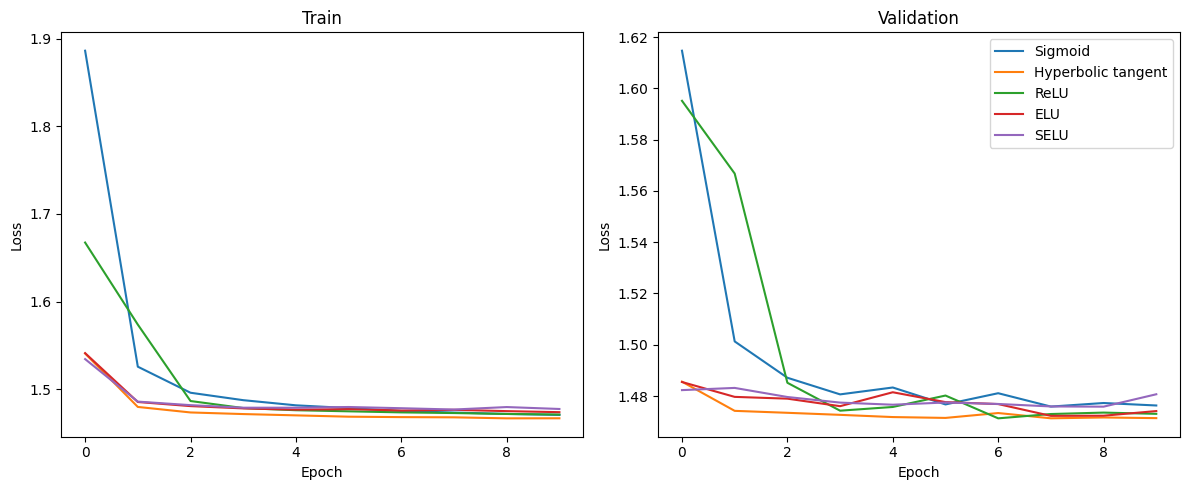

In [ ]:
plot_by_activation(MNIST_train_losses, MNIST_val_losses, "Loss")

From the plot depicting the evolution of loss, we see that the sigmoid achieved higher loss in the early epochs. Regarding the rest of the functions, we see that they achieved similar loss values.

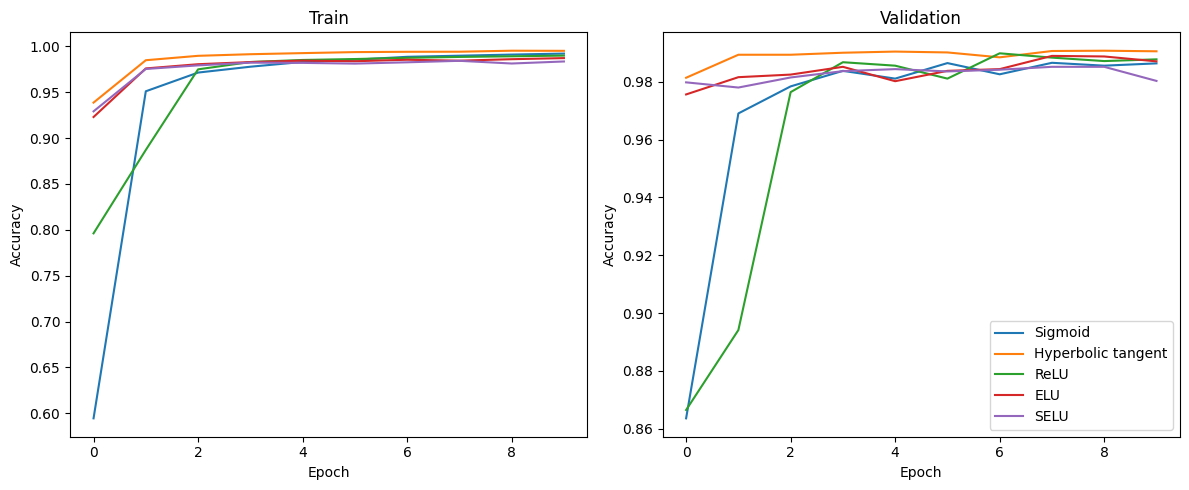

In [ ]:
plot_by_activation(MNIST_train_accs, MNIST_val_accs, "Accuracy")

We observe that in the end, the rest of the models achieved very similar performance. Finally, we need to be mindful that the obtained results also depend on the CNN architecture used. Different architectures might be differently suitable for given dataset and hyper-parameter selection.

As the next part of the evaluation of models trained on MNIST, let us observe some of the misclassified validation images (as a reference model, we choose the one using Hyperbolic tangent activation):

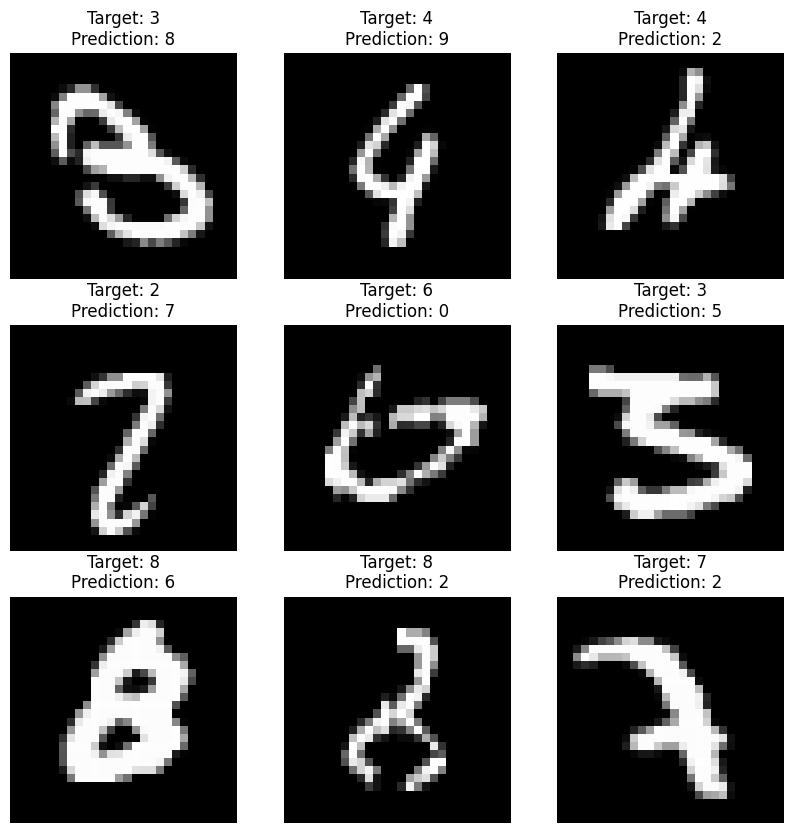

In [ ]:
ht_model = MNIST_models[1]
ims, targets, preds = get_k_missclassified(9, ht_model, MNIST_test_dataloader)
show_images(ims, targets, preds)

Arguably, the errors that our model makes are very questionable. Majority of mistakes it makes, would result in a mistake also from a human being. It is up to discussion whether these are mistakes in the dataset, errors of our models, or just a noise.

Finally, let us obsere a per-class accuracy (multiclass recall) for each model:

In [ ]:
data = {}
for name, model in zip(activation_labels, MNIST_models):
    data[name] = per_class_accuracy(model, MNIST_test_dataloader, 10)

pd.DataFrame(data)

,Sigmoid,Hyperbolic tangent,ReLU,ELU,SELU
0,0.995918,0.996939,0.996939,0.994898,0.994898
1,0.998238,0.995595,0.997357,0.998238,0.951542
2,0.990310,0.992248,0.985465,0.980620,0.975775
3,0.993069,0.994059,0.980198,0.988119,0.996040
4,0.993890,0.991853,0.992872,0.987780,0.988798
5,0.984305,0.994395,0.993274,0.995516,0.983184
6,0.975992,0.983299,0.984342,0.985386,0.978079
7,0.991245,0.986381,0.986381,0.980545,0.993191
8,0.971253,0.986653,0.975359,0.984600,0.971253
9,0.966303,0.983152,0.984143,0.974232,0.973241


We can observe, that on average, the worst accuracy is achieved on digits that are similar with some other digits (like '6' and '9' for instance).

### CIFAR10 evaluation

Similar to the MNIST evaluation, we first show the achievied metrics per node function used:

In [ ]:
metrics_by_activation(CIFAR10_train_losses, CIFAR10_val_losses, CIFAR10_train_accs, CIFAR10_val_accs)

,Train loss,Validation loss,Train accuracy,Validation accuracy
Sigmoid,1.821217,1.892659,0.657089,0.567576
Hyperbolic tangent,1.672035,1.766291,0.794337,0.693372
ReLU,1.668610,1.747619,0.792579,0.711883
ELU,1.686017,1.772194,0.774057,0.687201
SELU,1.786734,1.790995,0.673713,0.668989


We observe that regarding the train accuracy, again, **Hyperbolic tangent** and **ReLU** seem to perform the best. On the validation set, the **ReLU** is significantly the best option. Also, notice that the accuracies on validation dataset and considerably smaller than on training one, which might indicate overfitting.

Next, we show the evolution of loss and accuracy for both train and validation datasets by epoch:

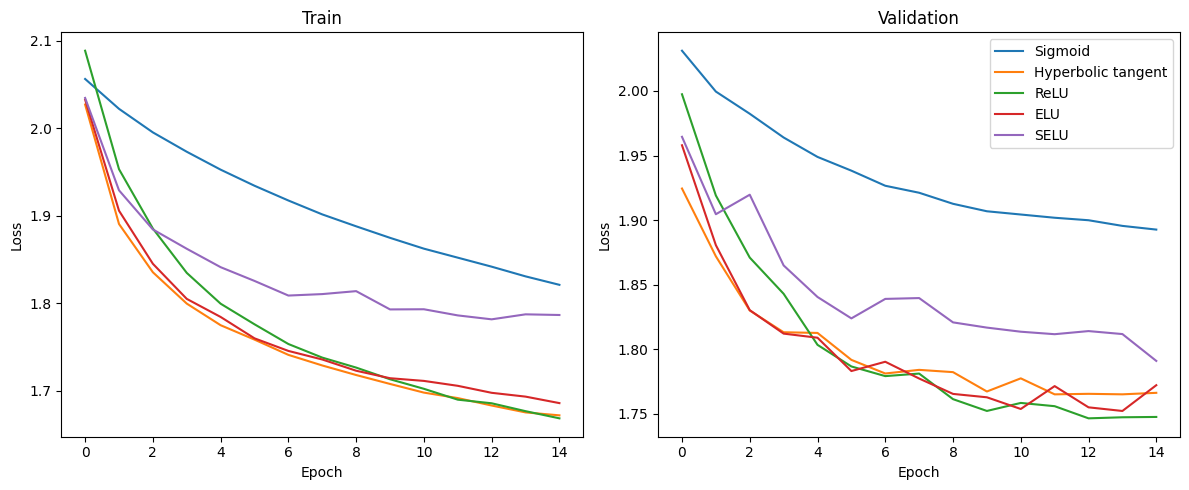

In [ ]:
plot_by_activation(CIFAR10_train_losses, CIFAR10_val_losses, "Loss")

We see that sigmoid node function tends to lag behind in this case. CIFAR10 is more difficult dataset, thus, it indicates troubles with training deep CNN with sigmoid activations in hidden layers. Also, notice that the loss on train dataset is smoother than on validation one.

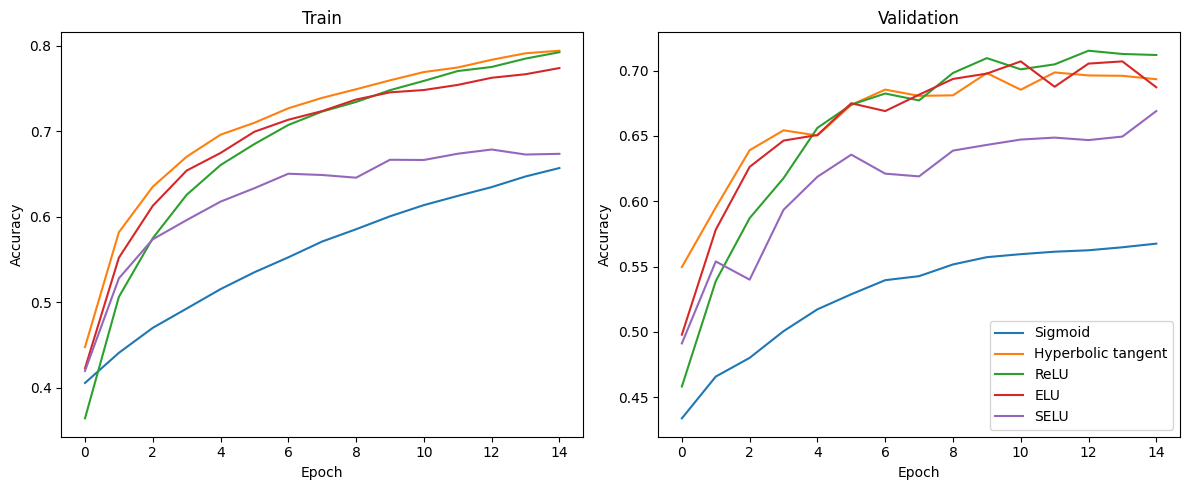

In [ ]:
plot_by_activation(CIFAR10_train_accs, CIFAR10_val_accs, "Accuracy")

Regarding the accuracies, they similar observations hold as for the losses. Namely, CNN using sigmoid is performing significantly worse than other ones. Also, the accuracy evolution is smoother on train dataset. As we demonstrated earlier, ReLU and Hyperbolic tangent seem to be the best options.

Next, we fix the model using ReLU activation (since it is the best one) and see what mistakes it makes:

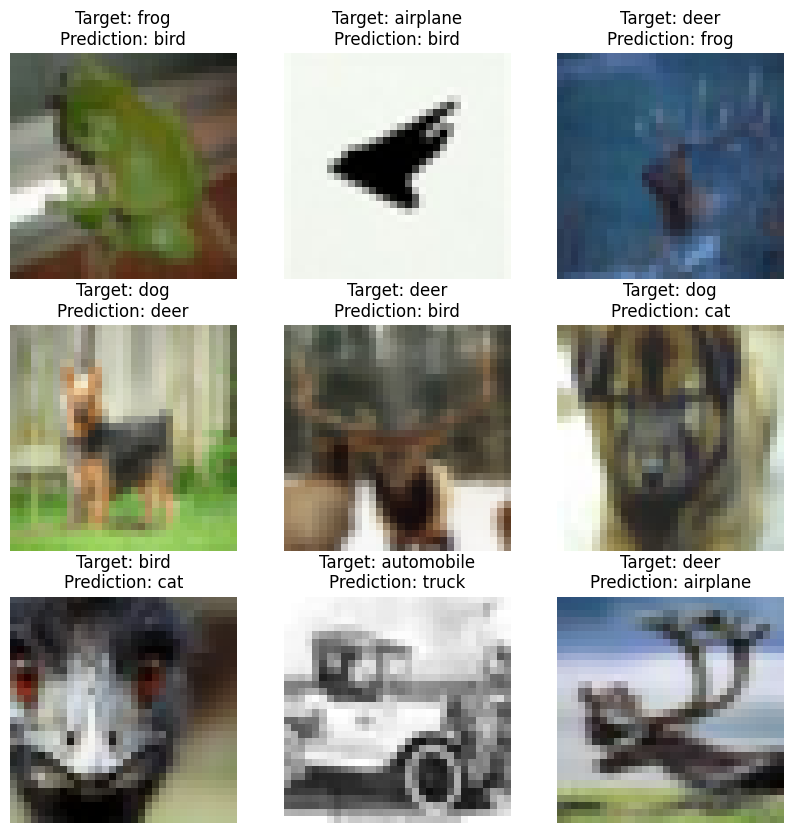

In [ ]:
r_model = CIFAR10_models[2]
ims, targets, preds = get_k_missclassified(9, r_model, CIFAR10_test_dataloader)
show_images(ims, [CIFAR10_translate[i] for i in targets], [CIFAR10_translate[i] for i in preds], mnist=False)

We observe that some mistakes are really mistakes, however, some of them are very tough to decide even for human observer. Thus, we conclude that our models really learnt something.

Finally, let us demonstrate the per-class accuracy of each model:

In [ ]:
data = {}
for name, model in zip(activation_labels, CIFAR10_models):
    data[name] = per_class_accuracy(model, CIFAR10_test_dataloader, 10)

df = pd.DataFrame(data)
df.index = CIFAR10_translate
df

,Sigmoid,Hyperbolic tangent,ReLU,ELU,SELU
airplane,0.617,0.773,0.733,0.768,0.757
automobile,0.700,0.812,0.836,0.794,0.796
bird,0.402,0.492,0.599,0.440,0.495
cat,0.547,0.583,0.570,0.569,0.421
deer,0.370,0.602,0.580,0.561,0.665
dog,0.507,0.609,0.599,0.595,0.544
frog,0.587,0.780,0.810,0.785,0.776
horse,0.602,0.721,0.757,0.649,0.681
ship,0.696,0.774,0.831,0.839,0.779
truck,0.645,0.791,0.802,0.869,0.778


Notice that each model is struggling with classifing birds, while it is relatively easy to distinguish car from the rest. This might be caused by the fact that bird is both animal and is flying, which is common for more classes in our dataset.